<a href="https://colab.research.google.com/github/Goshective/Project_ML/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

## Все библиотеки

In [2]:
!pip install kaggle
!pip install torch torchvision
!pip install pytorch-ignite
!pip install torchshow
!pip install torcheval

In [3]:
from google.colab import files
import zipfile
import os

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd

import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Normalize, PILToTensor
from torch import nn
from torchsummary import summary
import torchshow

from torcheval.metrics import MulticlassAccuracy, MulticlassF1Score
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Accuracy, Loss, Precision, Recall, Fbeta
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

In [4]:
# Upload the Kaggle API key file
uploaded = files.upload()

# Move the uploaded file to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
# Download the dataset
!kaggle competitions download -c ml-intensive-yandex-autumn-2023

ml-intensive-yandex-autumn-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


Перевод в zip

In [6]:
zip_file_path = "ml-intensive-yandex-autumn-2023.zip"
extracted_folder = "dataset"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_folder)

In [7]:
!ls -l dataset/data/

total 2268
drwxr-xr-x 2 root root 212992 Dec 17 08:18 test_images
-rw-r--r-- 1 root root 204908 Dec 17 10:26 train_answers.csv
drwxr-xr-x 2 root root 950272 Dec 17 08:18 train_images
drwxr-xr-x 2 root root 950272 Dec 17 08:18 train_lung_masks


## Перевод в датасеты

Находим пути, определяем константы

In [8]:
TEST_RANGE = 6920
TEST_MODE = 105106
IMAGE_SHAPE = 256
NAMES = ["Normal", "Non_covid", "Covid_19"]

# Define paths
data_folder = "dataset/data"
train_images_folder = os.path.join(data_folder, "train_images")
train_masks_folder = os.path.join(data_folder, "train_lung_masks")
test_images_folder = os.path.join(data_folder, "test_images")
train_ans_path = os.path.join(data_folder, "train_answers.csv")

In [9]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_folder, masks_folder=None, transform=None, mode=None):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.transform = transform
        self.mode = mode
        self.masks_folder = masks_folder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # load image from folder
        img_name = os.path.join(self.images_folder, f'img_{self.dataframe.iloc[idx, 0]}.png')
        image = Image.open(img_name).convert("L")

        if self.transform:
            image = self.transform(image)

        if self.mode == TEST_MODE:  # for test images we have only image
            return image

        if self.masks_folder:  # train the creation of masks by images
            id = self.dataframe.iloc[idx, 0]
            mask_name = os.path.join(self.images_folder, f'img_{id}.png')
            mask = Image.open(mask_name).convert("L")
            ans = self.dataframe["target_feature"][idx]
            if self.transform:
                mask = self.transform(mask)
                empt = torch.zeros(1, 256, 256)
                lst = []
                for i in range(3):
                  if i == ans:
                    lst.append(mask)
                  else:
                    lst.append(empt)
                tr = torch.cat(lst, 0)
            return image, tr

        return image, self.dataframe["target_feature"][idx]

# Define transformations
transform = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5,), (0.25,))
])

transform2 = Compose([
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5,), (0.25,))
])
# Create datasets
train_ans_pd = pd.read_csv(train_ans_path)
train_ans_tensor = torch.tensor(train_ans_pd["target_feature"].values) # to tensor

train_mask_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=train_images_folder, masks_folder=train_masks_folder, transform=transform2)
train_image_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=train_images_folder, transform=transform)

test_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=test_images_folder, transform=transform, mode=TEST_MODE)

print(train_image_dataset[0][0].shape,
      train_image_dataset[0][1])


train_ans_pd


torch.Size([1, 256, 256]) 0


,id,target_feature
0,0,0
1,1,2
2,2,2
3,3,0
4,4,1
...,...,...
26995,26995,0
26996,26996,2
26997,26997,1
26998,26998,2


In [10]:
# for img in train_image_dataset:
#   print(type(img))
#   break
# train_image_tensor = torch.stack([item for item in train_image_dataset])
# train_image_tensor.shape

# train_set = torch.cat((train_image_tensor, train_ans_tensor), dim=1)

# train_set[0][1]
train_mask_dataset[2]

(tensor([[[ 0.1647, -0.9333, -1.9529,  ..., -1.9686, -1.9529, -1.8902],
          [ 0.4784, -0.8235, -1.9529,  ..., -1.9529, -1.9373, -1.8745],
          [ 0.4157, -0.8706, -1.9529,  ..., -1.9529, -1.9373, -1.8745],
          ...,
          [-1.9216, -1.9059, -1.9059,  ..., -1.9059, -1.9059, -1.9216],
          [-1.9059, -1.8902, -1.9059,  ..., -1.9059, -1.9059, -1.9216],
          [-1.9216, -1.9216, -1.9216,  ..., -1.9216, -1.9216, -1.9373]]]),
 tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,

## Проверка данных

In [11]:
train_image_loader = DataLoader(train_image_dataset, batch_size=32) # not using later
train_mask_loader = DataLoader(train_mask_dataset, batch_size=32)

for img, ans in train_image_loader:
  print(img.shape)
  print(img[0], ans[31])  # because of batch
  break

for img, mask in train_mask_loader:
  print(img.shape, mask.shape)
  break

print(train_ans_tensor[0])

torch.Size([32, 1, 256, 256])
tensor([[[-1.3569, -1.7490, -1.9059,  ..., -1.9373, -1.9373, -1.9529],
         [-1.3882, -1.7647, -1.9059,  ..., -1.9373, -1.9373, -1.9529],
         [-1.4039, -1.7647, -1.9216,  ..., -1.9373, -1.9373, -1.9529],
         ...,
         [ 0.6039,  0.1647, -0.1020,  ..., -0.4941,  0.4157,  0.4627],
         [ 0.8863,  0.4627,  0.2588,  ...,  0.5412,  1.3412,  1.2314],
         [ 1.2784,  0.8863,  0.6980,  ...,  1.9686,  2.0000,  1.6235]]]) tensor(2)
torch.Size([32, 1, 256, 256]) torch.Size([32, 3, 256, 256])
tensor(0)


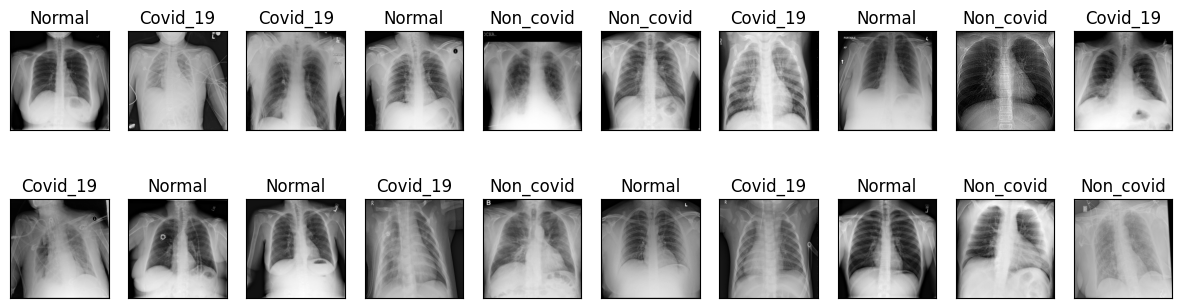

In [12]:
plt.figure(figsize=(15,4))

for i, (img, ans) in enumerate(train_image_dataset):
    if i == 20:
      break
    plt.subplot(2, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0) * 0.25 + 0.5, cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.title(NAMES[ans])

plt.show()

# Baseline решение

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Модели

* model_cur - текущая модель

**Игрушечная модель**

*  Без доп. предобработки данных за 10 эпох: accuracy = 67%, f1 = 68%

*  В режиме GPU: одна эпоха за 1 мин. 50 с.

In [ ]:
model_0 = nn.Sequential(
    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=256**2, out_features=3),
    nn.Softmax(dim=1),
).to(device)

print(summary(model_0, (1, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 65536]               0
            Linear-2                    [-1, 3]         196,611
           Softmax-3                    [-1, 3]               0
Total params: 196,611
Trainable params: 196,611
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.50
Params size (MB): 0.75
Estimated Total Size (MB): 1.50
----------------------------------------------------------------
None


**Свёрточная сеть с 10^5 параметрами**

*  Без доп. предобработки данных за 10 эпох: accuracy = 80%, f1 = 79%

*  В режиме GPU - 1 эпоха за 2 мин. 20 с.

*  Добавление слоёв Dropout приблизило графики valid и train (нет переобучения)

In [ ]:
model_1 = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(4, 4),  # -> (16, 256, 256) -> (16, 64, 64)

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(4, 4),  # -> (32, 64, 64) -> (32, 16, 16)
    nn.Dropout2d(p=0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(4, 4),  # -> (64, 16, 16) -> (64, 4, 4)
    nn.Dropout2d(p=0.2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(4, 4),  # -> (128, 4, 4) -> (128, 1, 1)

    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=128, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=3),
    nn.Softmax(dim=1),
).to(device)

print(summary(model_1, (1, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
              ReLU-6           [-1, 32, 64, 64]               0
       BatchNorm2d-7           [-1, 32, 64, 64]              64
         MaxPool2d-8           [-1, 32, 16, 16]               0
         Dropout2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
        MaxPool2d-13             [-1, 64, 4, 4]               0
        Dropout2d-14             [-1, 6

**Свёрточная сеть с 10^6 параметрами**

*  Без доп. предобработки данных за 10 эпох: accuracy = 85%, f1 = 85%

*  В режиме GPU - 1 эпоха за 2 мин. 40 с.

In [ ]:
model_cur = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2, 2),  # -> (16, 256, 256) -> (16, 128, 128)

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),  # -> (32, 128, 128) -> (32, 64, 64)
    nn.Dropout2d(p=0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),  # -> (64, 64, 64) -> (64, 32, 32)
    nn.Dropout2d(p=0.2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2, 2),  # -> (128, 32, 32) -> (128, 16, 16)

    nn.Conv2d(128, 256, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(4, 4), # -> (256, 16, 16) -> (256, 4, 4)

    nn.Conv2d(256, 256, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(4, 4),  # -> (256, 4, 4) -> (256, 1, 1)

    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=256, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=3),
    nn.Softmax(dim=1),
).to(device)

print(summary(model_cur, (1, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
              ReLU-6         [-1, 32, 128, 128]               0
       BatchNorm2d-7         [-1, 32, 128, 128]              64
         MaxPool2d-8           [-1, 32, 64, 64]               0
         Dropout2d-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          18,496
             ReLU-11           [-1, 64, 64, 64]               0
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        MaxPool2d-13           [-1, 64, 32, 32]               0
        Dropout2d-14           [-1, 64,

Проверка формата входа и выхода модели

In [ ]:
rand_tensor = torch.rand((32, 1, 256, 256))
pred = model_cur(rand_tensor.to(device))
pred.shape

torch.Size([32, 3])

## Настройка цикла обучения

### Разделение выборки

In [ ]:
train_set, valid_set = random_split(train_image_dataset, (0.95, 0.05))

train_set[0]

(Image([[[-1.9059, -1.8275, -1.7804,  ..., -1.1843, -1.1686, -1.9686],
         [-1.9059, -1.8431, -1.7961,  ..., -1.9843, -2.0000, -1.9529],
         [-1.9059, -1.8431, -1.7961,  ..., -1.9216, -1.9373, -1.9686],
         ...,
         [-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
         [-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
         [-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000]]], ),
 2)

### Константы для обучения

In [ ]:

BATCH_SIZE = 32  # contains most likely all categories of pictures
NUM_EPOCHS = 15
NUM_LOG_ITERS = 200  # as the number decreases, it often displays lr per epoch

metrics_hist = {"train":
                          {"accuracy": [], "loss": [], "f1": []},
                "valid":
                          {"accuracy": [], "loss": [], "f1": []}
                }


optimizer = torch.optim.SGD(model_cur.parameters(), lr=0.001) # not too slow to minimize
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

for X,y in train_loader:
  print(X.shape, y.shape)
  print(X[0].shape)
  break

torch.Size([32, 1, 256, 256]) torch.Size([32])
torch.Size([1, 256, 256])


In [ ]:

for a,b in train_loader:
  print(a.shape)
  ppp = model_cur(a.to(device))
  ppp2 = ppp.squeeze()
  print(b.shape)
  print("result of model:", ppp.shape, "->", ppp2.shape)
  criterion(ppp2, b.to(device))
  break

trainer = create_supervised_trainer(model_cur, optimizer, criterion, device)

precision = Precision(average=False)
recall = Recall(average=False)
F1 = Fbeta(beta=1.0, precision=precision, recall=recall, average=True)

metrics = {
    "loss": Loss(criterion),
    "accuracy": Accuracy(),
    "f1": F1  # needed to track the results of the competition in advance
}

train_evaluator = create_supervised_evaluator(model_cur, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model_cur, metrics=metrics, device=device)

torch.Size([32, 1, 256, 256])
torch.Size([32])
result of model: torch.Size([32, 3]) -> torch.Size([32, 3])


### Лог-функции и вывод графиков

In [ ]:
def show_metrics(hist: dict):
    clear_output()

    names = ['loss', 'accuracy', 'f1']
    modes = ['train', 'valid']

    plt.figure(figsize=(24,12))
    for i, name in enumerate(names):  # shows plot for every metric

        plt.subplot(1, len(names), i+1)
        plt.title(name.capitalize())

        for mode in modes:  # in train and valid mode
            range_metric = np.arange(len(hist[mode][name]))

            plt.plot(range_metric, hist[mode][name],
                    label=f"{mode} {name} = {hist[mode][name][-1]:.5f}")

        plt.legend()

        plt.yscale('log')
        plt.grid()

    plt.show()

In [ ]:
def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=NUM_LOG_ITERS), log_iter_loss)


def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)


def log_epoch_results(engine, label=""):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])

    for m, v in engine.state.metrics.items():  # lists each metric under consideration
        metrics_hist[label.lower()][m].append(v)


    # func is calling 2 times for train and valid
    if len(metrics_hist['valid']['loss']) == len(metrics_hist['train']['loss']):

        # no single point graphs
        if len(metrics_hist['valid']['loss']) > 1:

            show_metrics(metrics_hist)

        print(f"{temp_results[-1][0]} Res:", temp_results[-1][1])
        print(f"{label} Res:", result)
        temp_resulst = []

    else:
        temp_results.append((label, result))

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")
temp_results = []

LR Scheduler

In [ ]:

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

## Обучение

Обновите все предыдущие ячейки перед запуском (либо запустите "Baseline решение", как одну свёрнутую ячейку)

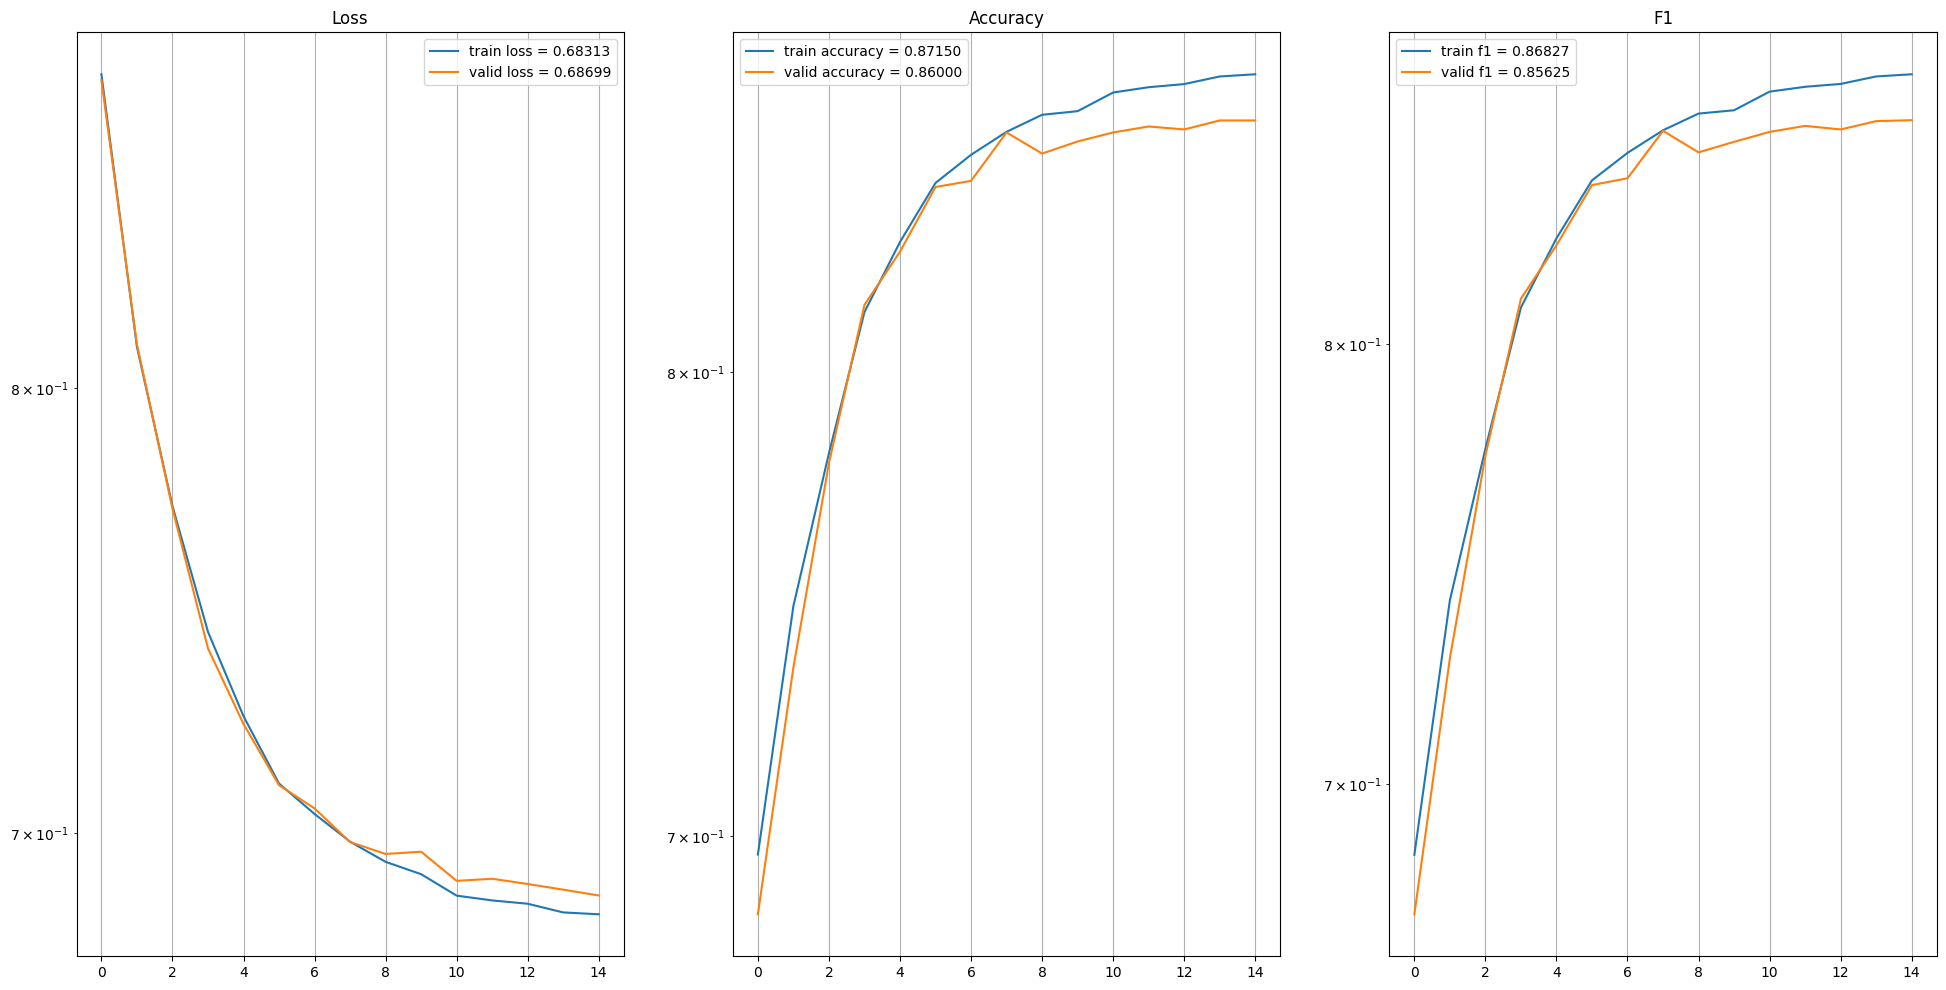

Train Res: loss = 0.6831276650828461, accuracy = 0.8715009746588694, f1 = 0.8682702205673608
Valid Res: loss = 0.6869913736979166, accuracy = 0.86, f1 = 0.8562491813202792
Optimizer learning rate = 6.25e-05


State:
	iteration: 12030
	epoch: 15
	epoch_length: 802
	max_epochs: 15
	output: 0.8108003735542297
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
trainer.run(train_loader, NUM_EPOCHS)

## Предсказания для теста

In [ ]:
print(test_dataset[0].shape)

model_cur.eval()
y_test = []
for i in range(TEST_RANGE):
    x = torch.stack([test_dataset[i],])  # convert to model input shape
    y_pred = torch.argmax(model_cur(x.to(device)))
    y_test.append(y_pred.item())

print(len(y_test), y_test[:2])

torch.Size([1, 256, 256])
6920 [0, 0]


In [ ]:
y_dataset = pd.DataFrame({'target_feature': y_test})
y_dataset

,target_feature
0,0
1,0
2,0
3,0
4,0
...,...
6915,0
6916,0
6917,0
6918,0


In [ ]:
# from google.colab import files

y_dataset.to_csv('df.csv', index_label='id')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Решение с масками



> Пробуем решение с сегментационной моделью. На вход подаётся обычное изображение из train выборки, на выход - бинарная маска в 3-х каналах. Только в одном канале, определяющем класс, маска единичная, в остальных - только нули. Таким образом при помощи сегментации модель будет выводить такую же маску, наибольшее значение в которой будет говорить о принадлежности к классу.

Плюсы:
 *  Вся классификация происходит внутри одной модели, следовательно потеря данных минимальна

 *  Легко сделать датасет ответов (2 пустые маски, одна из train датасета)

Минусы:
 *  Сложно точно сказать, какой класс выбрала модель, поскольку в каждом канале маска может быть разного размера

 * Сложно контроллировать внутренюю работу модели



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Модели для масок

In [14]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from torchvision.transforms import ToTensor

# Define the U-Net model
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels, lat_dim=32, p_size=256):
        super(SimpleUNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, lat_dim, kernel_size=3, padding=1),
        ).to(device)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(lat_dim, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        ).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # x = nn.functional.normalize(x, 0.5, 1, 0.25)
        return x


# Instantiate the model
t_model = SimpleUNet(lat_dim=32, in_channels=1, out_channels=3).to(device)

summary(t_model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
         LeakyReLU-2         [-1, 64, 256, 256]               0
       BatchNorm2d-3         [-1, 64, 256, 256]             128
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]          18,464
            Conv2d-6         [-1, 64, 128, 128]          18,496
         LeakyReLU-7         [-1, 64, 128, 128]               0
       BatchNorm2d-8         [-1, 64, 128, 128]             128
            Conv2d-9         [-1, 16, 128, 128]           9,232
        LeakyReLU-10         [-1, 16, 128, 128]               0
      BatchNorm2d-11         [-1, 16, 128, 128]              32
         Upsample-12         [-1, 16, 256, 256]               0
           Conv2d-13          [-1, 3, 256, 256]             435
          Sigmoid-14          [-1, 3, 2

In [ ]:
class SkipUNet(nn.Module):
    def __init__(self, lat_dim, in_channels, out_channels):
        super(SimpleUNet, self).__init__() #(3, 256, 256)

        self.skip = []

        self.stack1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)) #64, 128, 128
        self.stack2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), # (128, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # (128, 64, 64)
        )
        self.stack3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), # (256, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # (256, 32, 32)
        )
        self.stack4 = nn.Sequential(
            nn.ConvTranspose2d
        )
        self.stack5 = nn.Sequential()

        self.stack6 = nn.Sequential()

        # Encoder
        def encoder(self, x):
          self.skip.append(x)
          x = self.stack1(x)
          self.skip.append(x)
          x = self.stack2(x)
          self.skip.append(x)
          x = self.stack3(x)
          self.skip.append(x)

        # Decoder
        def decoder(self, x):
          x = self.stack4(x)
          x = torch.cat((x, self.skip[2]), 1)
          x = self.stack5(x)
          x = torch.cat((x, self.skip[1]), 1)
          x = self.stack5(x)
          x = torch.cat((x, self.skip[0]), 1)


    def forward(self, x):
        x = self.encoder(x).to(device)
        x = self.decoder(x).to(device)
        return x

cur_model = SimpleUNet(lat_dim=32, in_channels=1, out_channels=3).to(device)

summary(cur_model, (1, 256, 256))

## Настройка цикла обучения

### Вспомогательные функции

In [15]:
from tqdm import tqdm


def acc_f1_calculate(pred, real, acc_func, f1_func):
    results_pred = []
    for batch in pred:
        lst = []
        for elem in batch:
            lst.append(float(torch.sum(elem)))
        res = np.argmax(lst)  # choosing index of the most dedicated mask
        results_pred.append(res)
    results_real = []
    for batch in real:
        lst = []
        for elem in batch:
            lst.append(float(torch.sum(elem)))
        res = np.argmax(lst)
        results_real.append(res)

    tensor_pred = torch.tensor(results_pred)
    tensor_real = torch.tensor(results_real)

    acc = acc_func.update(tensor_pred, tensor_real)
    f1 = f1_func.update(tensor_pred, tensor_real)

    return acc.compute(), f1.compute()


def run_epoch(model, opt, loss, dataloader, acc_func, f1_func, is_train=True):
    model.train(is_train)
    total_loss = 0.0
    total_acc = 0.0
    total_f1 = 0.0
    with torch.set_grad_enabled(is_train):
        for x, y in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)
            l = loss(y, model(x))
            if (is_train):
                opt.zero_grad()
                l.backward()
                opt.step()

            total_loss += l.item()
            res = acc_f1_calculate(model(x), y, acc_func, f1_func)
            total_acc += res[0]
            total_f1 += res[1]
    return total_loss / len(dataloader.dataset), total_acc / len(dataloader.dataset), total_f1 / len(dataloader.dataset)

In [16]:
def plot_single_metric(metric, title, label, num_epochs):
    plt.title(title)
    plt.plot(metric, label=label)
    plt.grid()
    plt.legend()
    plt.yscale('log')
    plt.xticks(np.arange(num_epochs))


def plot_metrics(metrics: dict, num_epochs):
    names = ['loss', 'accuracy', 'f1']
    modes = ['train', 'valid']

    plt.figure(figsize=(21, 6))

    for i, metric_name in enumerate(names):
        plt.subplot(1, len(names), i+1)
        for mode in modes:
            plot_single_metric(metrics[mode][metric_name],
                               metric_name.capitalize(),
                               f'{mode.capitalize()} {metric_name.capitalize()} = {metrics[mode][metric_name][-1]:.5f}',
                               num_epochs)
            # shows plots with label and title

    plt.show()




In [17]:
def show_examples(model, dataset, size):
    model.eval()
    with torch.no_grad():
        idxs = np.random.randint(0, len(dataset), size)
        x = torch.stack([dataset[i][0] for i in idxs]).to(device)
        y = model(x)
        print("Original images")
        torchshow.show(x, nrows=1, figsize=(12, 2), channel_mode="channel_first")
        print("Generated masks")
        torchshow.show(y, nrows=1, figsize=(12, 2))

In [18]:
from IPython.display import clear_output

def run_train_loop(model, opt, loss, train_loader, val_loader, num_epochs, ex_size, acc_func, f1_func):
    metrics_hist = {"train":
                          {"accuracy": [], "loss": [], "f1": []},
                    "valid":
                          {"accuracy": [], "loss": [], "f1": []}
                    }
    for e in range(num_epochs):
        print("Training...")

        train_loss, train_acc, train_f1 = run_epoch(model, opt, loss, train_loader, acc_func, f1_func,)
        metrics_hist["train"]["loss"].append(train_loss)
        metrics_hist["train"]["accuracy"].append(train_acc)
        metrics_hist["train"]["f1"].append(train_f1)

        print("Validating...")
        val_loss, val_acc, val_f1 = run_epoch(model, opt, loss, val_loader, acc_func, f1_func, is_train=False)
        metrics_hist["valid"]["loss"].append(val_loss)
        metrics_hist["valid"]["accuracy"].append(val_acc)
        metrics_hist["valid"]["f1"].append(val_f1)

        clear_output()

        plot_metrics(metrics_hist, num_epochs)
        show_examples(model, val_loader.dataset, ex_size)

### Константы для обучения

Проверка данных

In [19]:
BATCH_SIZE = 100
NUM_EPOCHS = 5
# LAT_DIM = 8
EXAMPLE_SIZE = 8

train_set, valid_set = random_split(train_mask_dataset, (0.95, 0.05))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

acc_func = MulticlassAccuracy()
f1_func = MulticlassF1Score()

s_model_opt = torch.optim.Adam(cur_model.parameters())
s_model_loss = nn.MSELoss(reduction='sum')

## Обучение

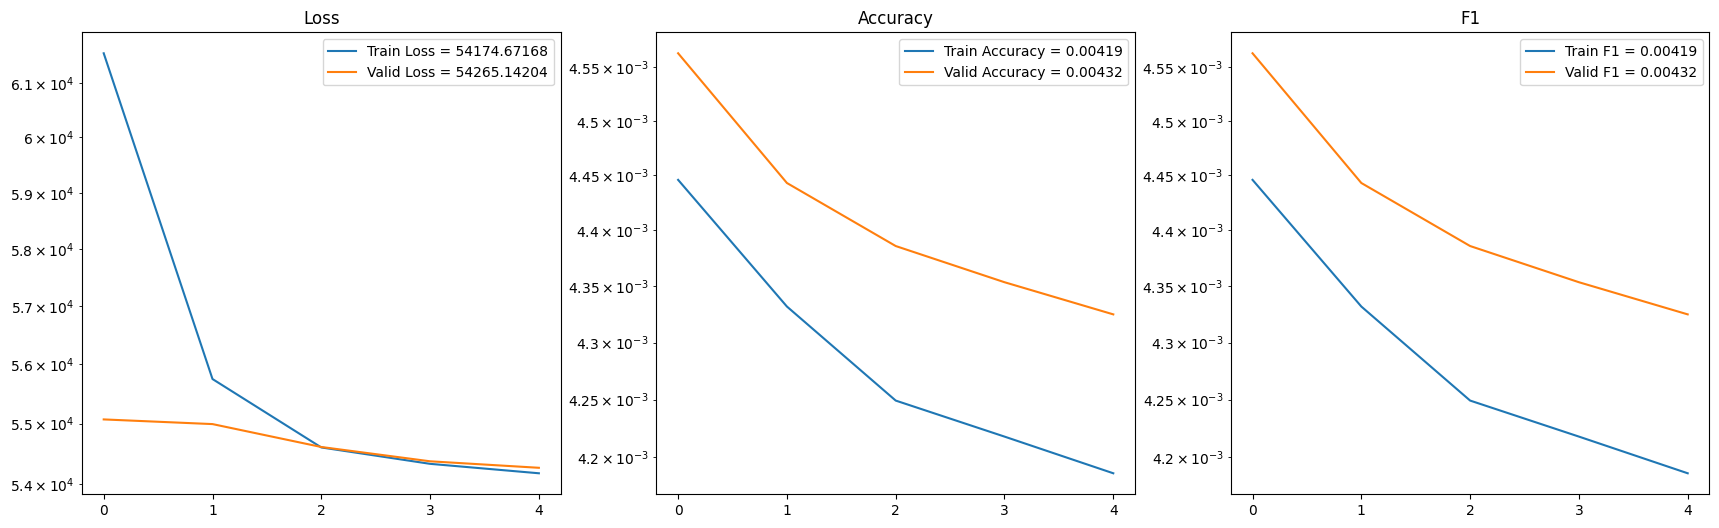

Original images


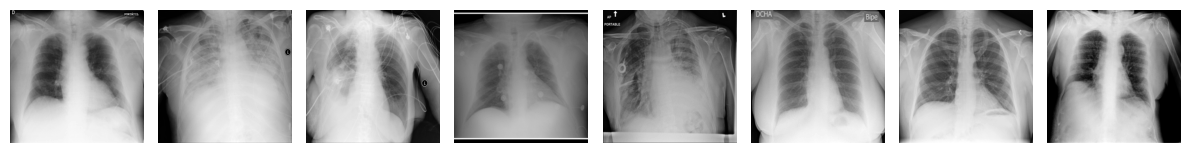

Generated masks


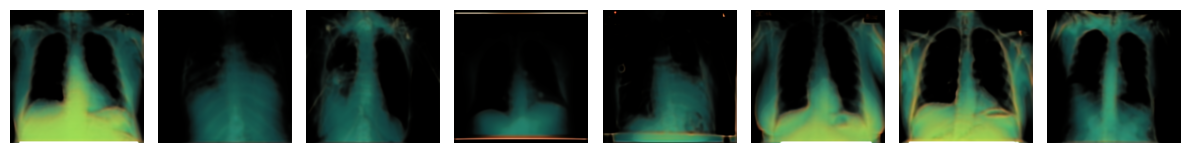

In [20]:
run_train_loop(cur_model, s_model_opt, s_model_loss,
               train_loader, valid_loader, NUM_EPOCHS, EXAMPLE_SIZE,
               acc_func, f1_func)